In [1]:
# Basic libraries
import pandas as pd
import numpy as np

# Utils
# import lux
# import itertools
import datetime

# DataViz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data libraries
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Schedule

### Exploratory Data Analysis
- Feature Engineering: discretizing and combining some variables.
- Univariate analysis
- Bivariate analysis

Let's keep an easy access to the data dictonary:

<img src="../images/data_dict.jpg" width="600" height="300">

### 0. Loading dataset and reviewing it

In [2]:
ccustomers = pd.read_csv('../data/customers_cleaned.csv') # ccustomers: cleaned customers 
ccustomers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [3]:
ccustomers.shape

(2233, 27)

Since we will be using `Dt_Customer` for Feature Engineering, let's check the type of the date with `dtypes`.

In [4]:
ccustomers['Dt_Customer'].dtypes

dtype('O')

As an `object` (pandas way to say `str`) we won't be able to perform date operations. We need to transform it into a `datetime` object.

In [5]:
# Transforming Dt_Customer variable into a python datetime object
ccustomers['Dt_Customer'] = pd.to_datetime(ccustomers['Dt_Customer'])

We are all set. Let's mix some data.

## 1. Feature Engineering

Looking back at the Data Dictionary we can list some operations that might result interesting:

- Transform `Year_Birth` in `Age`.

### 1.1 Creating `Age` variable

In order to calculate the age of every client in our dataset, first it is important to determine **when** the dataset was generated.

If we knew that the dataset was sampled in 2014 (the most recent day a client entered) we could simple calculate 

We cannot determine when today _was_!


The dataset, as instructed, is a _random sample_ of hundreds of thousand of clients in the database.

In order to get the customers' `Age` we need to investigate the time span of our data.  

In [7]:
min_date, max_date = ccustomers['Dt_Customer'].min().strftime('%d-%m-%Y'), \
                            ccustomers['Dt_Customer'].dt.date.max().strftime('%d-%m-%Y')

print('First date in our sample dataset is: ', min_date)
print('Last  date in our sample dataset is: ', max_date)

# Calculating timespan from max_date and min_date
span_df_months = (pd.to_datetime(max_date) - pd.to_datetime(min_date)) // np.timedelta64(1, 'M')
span_df_weeks = (pd.to_datetime(max_date) - pd.to_datetime(min_date)) // np.timedelta64(1, 'W')

print(f'\nOur data spans throughout {span_df_months} months (equivalent to {span_df_weeks} weeks).')

First date in our sample dataset is:  30-07-2012
Last  date in our sample dataset is:  29-06-2014

Our data spans throughout 22 months (equivalent to 99 weeks).


In [8]:
ccustomers[ccustomers['Dt_Customer'] == ccustomers['Dt_Customer'].max()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
199,7300,1952,Graduation,Divorced,69142.0,0,1,2014-06-29,50,448,4,34,6,4,39,3,8,1,7,5,0,1,0,0,0,0,0
986,453,1956,PhD,Widow,35340.0,1,1,2014-06-29,1,27,0,12,0,1,5,2,2,0,3,5,0,0,0,0,0,0,0


In [9]:
ccustomers[ccustomers['Recency'] == ccustomers['Recency'].max()].sort_values('Dt_Customer', ascending = False).head(1)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
1797,2831,1976,Graduation,Together,78416.0,0,1,2014-06-27,99,453,38,279,188,38,183,2,7,7,10,3,0,0,0,0,0,0,0


In [10]:
# ccustomers['Marital_Status'].value_counts().plot(kind = 'bar')

In [11]:
# Create dataset with features of interest
age_analysis = ccustomers[['Year_Birth', 'Dt_Customer', 'Recency']]

# Parse dates to Year-Month
age_analysis['year_month'] = ccustomers['Dt_Customer'].dt.strftime('%Y-%m')
age_analysis['year_week'] = ccustomers['Dt_Customer'].dt.strftime('%Y-%V')

# Group data by Year-Month
age_analysis_grouped_month_year = age_analysis.groupby(by = 'year_month').count()
age_analysis_grouped_week_year = age_analysis.groupby(by = 'year_week').count()

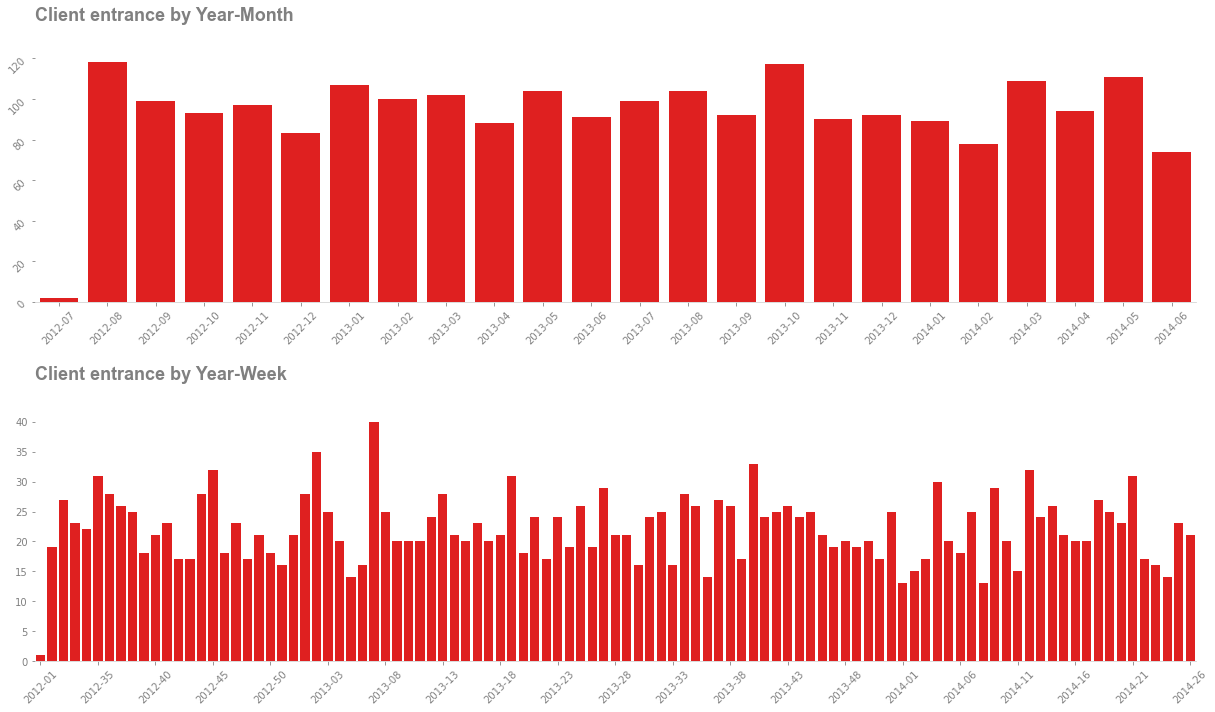

In [12]:
# Setting up plots
fig, ax = plt.subplots(2, 1, figsize = (17, 10))
sns.despine(top = True, left = True)

# Plot Year-Month Distribution
sns.barplot(x = age_analysis_grouped_month_year.index, 
            y = age_analysis_grouped_month_year['Year_Birth'], 
            ax = ax[0], 
            color = 'red')
ax[0].set(ylabel = None, xlabel = None)
ax[0].set_title('Client entrance by Year-Month', loc = 'left', size = 18, 
                pad = 30, fontweight = 'bold', fontname = 'Arial', color = 'gray')
ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray', rotation = 45)

# Plot Year-Year_week Distribution
sns.barplot(x = age_analysis_grouped_week_year.index, 
            y = age_analysis_grouped_week_year['Year_Birth'], 
            ax = ax[1],
            color = 'red')
ax[1].set_title('Client entrance by Year-Week',  loc = 'left', size = 18, 
                pad = 30, fontweight = 'bold', fontname = 'Arial', color = 'gray')
ax[1].set(ylabel = None, xlabel = None)
ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
plt.xticks(np.arange(0, len(age_analysis_grouped_week_year.index), step = 5), 
           rotation = 45)

plt.tight_layout(h_pad = 2);

In [ ]:
ccustomers[ccustomers['Dt_Customer'] == ccustomers['Dt_Customer'].min()]

In [ ]:
to_count = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
for var in to_count:
    print(ccustomers[var].value_counts(), '\n================================ \n')

In [ ]:
purchase_flow = ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]
purchase_flow['total'] = np.sum(ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']], axis = 1)
# np.sum(np.array(ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]), axis = 1)
ccustomers[purchase_flow['total'] == 5]

In [ ]:
ccustomers['Recency'].hist();

In [ ]:
ccustomers['Response'].value_counts()

In [ ]:
ccustomers[ccustomers['Response'] == 1]['Recency'].hist()
ccustomers[ccustomers['Response'] == 0]['Recency'].hist()